In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=693b4906d0ce603f0cd74a915dcd85fc266364233b6455cdafba959b901df0cf
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


Các thư viện cần thiết cho bài toán

In [ ]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, when, mean
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, IntegerType
import pandas as pd


Khởi tạo SparkSession

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Đọc dữ liệu

In [ ]:
application_train = spark.read.csv('application_train.csv', header=True, inferSchema=True)
bureau = spark.read.csv('bureau.csv', header=True, inferSchema=True)

Dữ liệu bảng application

In [ ]:
application_train.show(5)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

Dữ liệu bảng bureau

In [ ]:
bureau.show(5)

+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|DAYS_CREDIT|CREDIT_DAY_OVERDUE|DAYS_CREDIT_ENDDATE|DAYS_ENDDATE_FACT|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|    CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|    215354|     5714462|       Closed|     currency 1|       -497|                 0|             -153.0|           -153

In [ ]:
application_train.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [ ]:
bureau.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)



Số dòng, cột bảng application

In [ ]:
num_rows = application_train.count()
num_cols = len(application_train.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 307511
Number of columns: 122


Số dòng, cột bảng bureau

In [ ]:
num_rows = bureau.count()
num_cols = len(bureau.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 1716428
Number of columns: 17


# Xử lý dữ liệu


Các giá trị khuyết thiếu của hai bảng dữ liệu.

In [ ]:
from pyspark.sql.functions import col, count, when

application_train.select([count(when(col(c).isNull(), c)).alias(c) for c in application_train.columns]).show()

bureau.select([count(when(col(c).isNull(), c)).alias(c) for c in bureau.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

In [ ]:
from pyspark.sql.functions import col, count, when
def missing_values(df):
    missing_values_count = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()

    missing_values_percentage = {c: (missing_values_count[c] / df.count()) * 100 for c in df.columns}

    missing_values_df = spark.createDataFrame([(c, missing_values_count[c], missing_values_percentage[c]) for c in df.columns], ["Column Name", "Missing Values", "Percentage"])

    return missing_values_df

In [ ]:
train_miss=missing_values(application_train).orderBy(col('Percentage').desc())

Phần trăm khuyết thiếu của bảng application

In [ ]:
train_miss.show()

+--------------------+--------------+------------------+
|         Column Name|Missing Values|        Percentage|
+--------------------+--------------+------------------+
|     COMMONAREA_MODE|        214865| 69.87229725115525|
|      COMMONAREA_AVG|        214865| 69.87229725115525|
|     COMMONAREA_MEDI|        214865| 69.87229725115525|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|  FONDKAPREMONT_MODE|        210295| 68.38617155158677|
|LIVINGAPARTMENTS_AVG|        210199| 68.35495315614726|
|LIVINGAPARTMENTS_...|        210199| 68.35495315614726|
|LIVINGAPARTMENTS_...|        210199| 68.35495315614726|
|       FLOORSMIN_AVG|        208642| 67.84862980511267|
|      FLOORSMIN_MODE|        208642| 67.84862980511267|
|      FLOORSMIN_MEDI|        208642| 67.84862980511267|
|     YEARS_BUILD_AVG|        204488| 66.49778381911543|
|    YEARS_BUILD_MODE|        2

Phần trăm dữ liệu thiếu của bảng bureau

In [ ]:
bureau_miss=missing_values(bureau).orderBy(col('Percentage').desc())
bureau_miss.show()

+--------------------+--------------+--------------------+
|         Column Name|Missing Values|          Percentage|
+--------------------+--------------+--------------------+
|         AMT_ANNUITY|       1226791|    71.4734902949614|
|AMT_CREDIT_MAX_OV...|       1124488|   65.51326359159837|
|   DAYS_ENDDATE_FACT|        633653|  36.916957775100386|
|AMT_CREDIT_SUM_LIMIT|        591780|   34.47741472406649|
| AMT_CREDIT_SUM_DEBT|        257669|  15.011931755948982|
| DAYS_CREDIT_ENDDATE|        105553|   6.149573416420613|
|      AMT_CREDIT_SUM|            13|7.573868522303295E-4|
|          SK_ID_CURR|             0|                 0.0|
|  CNT_CREDIT_PROLONG|             0|                 0.0|
|        SK_ID_BUREAU|             0|                 0.0|
|AMT_CREDIT_SUM_OV...|             0|                 0.0|
|       CREDIT_ACTIVE|             0|                 0.0|
|         CREDIT_TYPE|             0|                 0.0|
|     CREDIT_CURRENCY|             0|                 0.

Bỏ hết những cột thiếu hơn 50% dữ liệu của cả 2 bảng


In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
import numpy as np

numerical_cols = [col for col, dtype in application_train.dtypes if dtype in ['int', 'double']]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features", handleInvalid="skip") # Set handleInvalid to skip

df_vector = assembler.transform(application_train).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()
corr_array = correlation_matrix[0].toArray()

threshold = 0.5
upper_triangle = np.triu(corr_array, k=1)
to_drop = [numerical_cols[i] for i in range(len(numerical_cols))
           for j in range(i + 1, len(numerical_cols))
           if abs(upper_triangle[i, j]) > threshold]
application_train = application_train.drop(*to_drop)

In [ ]:
import numpy as np
numerical_cols = [col for col, dtype in bureau.dtypes if dtype in ['int', 'double']]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features", handleInvalid="skip") # Set handleInvalid to skip

df_vector = assembler.transform(bureau).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()
corr_array = correlation_matrix[0].toArray()

threshold = 0.5
upper_triangle = np.triu(corr_array, k=1)
to_drop = [numerical_cols[i] for i in range(len(numerical_cols))
           for j in range(i + 1, len(numerical_cols))
           if abs(upper_triangle[i, j]) > threshold]
bureau = bureau.drop(*to_drop)


điền những giá trị mean vào các ô thiếu giữ liệu mang kiểu int hoặc double của cả 2 bảng

In [ ]:
from pyspark.sql.functions import mean, count, when, col, isnull

means = application_train.select([mean(c).alias(c) for c in application_train.columns if c != 'TARGET']).collect()[0].asDict()

for column, mean_value in means.items():
    application_train = application_train.withColumn(column, when(isnull(col(column)), mean_value).otherwise(col(column)))

application_train.select([count(when(col(c).isNull(), c)).alias(c) for c in application_train.columns]).show()

+----------+------+------------------+-----------+------------+---------------+----------------+---------------+---------------+----------------+-------------------+------------------+-----------------+-----------------+---------------+-----------+----------+---------------+----------------+----------+----------+---------------+---------------+---------------------------+--------------------------+-----------------------+--------------------------+---------------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+-------------+------------------------+------------------+------------------+--------------+--------------+------------------+-------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+--

In [ ]:
means = bureau.select([mean(c).alias(c) for c in bureau.columns if c != 'SK_ID_PREV']).collect()[0].asDict()

for column, mean_value in means.items():
    bureau = bureau.withColumn(column, when(isnull(col(column)), mean_value).otherwise(col(column)))

bureau.select([count(when(col(c).isNull(), c)).alias(c) for c in bureau.columns]).show()


+----------+------------+-------------+---------------+------------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|CREDIT_DAY_OVERDUE|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+------------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|         0|           0|            0|              0|                 0|                     0|                 0|             0|                  0|                   0|                     0|          0|                 0|          0|
+----------+------------+-------------+-----

In [ ]:
null_counts = application_train.select([count(when(col(c).isNull(), c)).alias(c) for c in application_train.columns]).collect()[0].asDict()

cols_to_drop = [key for key, value in null_counts.items() if value > 90000]

application_train = application_train.drop(*cols_to_drop)


In [ ]:
application_train.select([count(when(col(c).isNull(), c)).alias(c) for c in application_train.columns]).show()

+----------+------+------------------+-----------+------------+---------------+----------------+---------------+---------------+----------------+-------------------+------------------+-----------------+-----------------+---------------+-----------+----------+---------------+----------------+----------+----------+---------------+---------------------------+--------------------------+-----------------------+--------------------------+---------------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+-------------+------------------------+------------------+--------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------

In [ ]:
bureau.select([count(when(col(c).isNull(), c)).alias(c) for c in bureau.columns]).show()

+----------+------------+-------------+---------------+------------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|CREDIT_DAY_OVERDUE|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+------------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|         0|           0|            0|              0|                 0|                     0|                 0|             0|                  0|                   0|                     0|          0|                 0|          0|
+----------+------------+-------------+-----

Nối 2 bảng application và bureau thông qua SK_ID_CURR

In [ ]:
from pyspark.sql import functions as F

bureau_agg = bureau.groupBy('SK_ID_CURR').agg(
    F.sum('AMT_CREDIT_SUM').alias('total_credit_sum'),
    F.mean('AMT_CREDIT_SUM_DEBT').alias('avg_credit_sum_debt'),
    F.count('*').alias('num_loans')
)
data_join = application_train.join(bureau_agg, on='SK_ID_CURR', how='left')

Loại bỏ giá trị trùng lặp

In [ ]:
data_join = data_join.dropDuplicates()

Số dòng và cột sau khi join 2 bảng lại với nhau

In [ ]:
num_rows = data_join.count()
num_cols = len(data_join.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 307511
Number of columns: 69


# Trực quan hóa dữ liệu

In [ ]:
data_join.groupBy('TARGET').count().show()

+------+------+
|TARGET| count|
+------+------+
|     1| 24825|
|     0|282686|
+------+------+



Biểu đồ cột thể hiện cột tagert

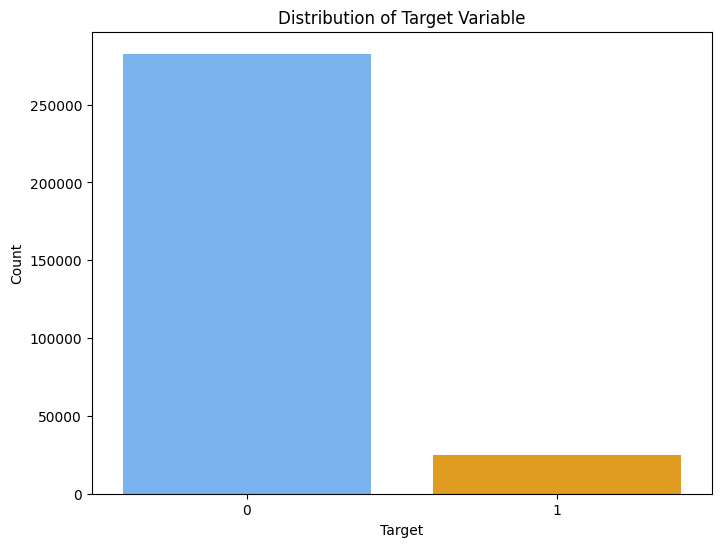

In [ ]:
colors = ['#66B2FF', 'orange']
target_counts = data_join.groupBy('TARGET').count().toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x='TARGET', y='count', data=target_counts, hue='TARGET', palette=colors, legend=False)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


Với 0 là những người có khả năng trả nợ

Với 1 là những người không có khả năng trả nợ

Nhận xét: có sự chênh lệch lớn giữa người có thể trả và không thể trả.

# Logistic Regression Model

In [ ]:
num_rows = data_join.count()
num_cols = len(data_join.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 307511
Number of columns: 69


In [ ]:
data_join.printSchema()

root
 |-- SK_ID_CURR: double (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_MOBIL: double (nullable = true)
 |-- FLAG_WORK_PHONE: double (nullable = true)
 |-- FLAG_CONT_MOBILE: double (nullable = true)
 |-- FLAG_PHONE: double (nullable = true)
 |-- FLAG_EMAIL: double (nullable = true)
 |-- CNT_FAM_MEMBERS: double (

Chọn các cột cần lấy để huấn luyện mô hình (tiêu chí chọn cột dựa trên hệ số tương quan của chúng với cột target), các cột này được chia làm 2 dựa trên dạng dữ liệu.

- categorical_col là các cột có kiểu dữ liệu string, object.

- numeric_cols là các cột có kiểu dữ liệu int, double.

In [ ]:
categorical_cols = [
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'ORGANIZATION_TYPE',
    'REGION_RATING_CLIENT_W_CITY',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
]

numeric_cols = [
    'CNT_FAM_MEMBERS',
    'AMT_INCOME_TOTAL',
    'AMT_GOODS_PRICE',
    'OWN_CAR_AGE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'total_credit_sum',
    'avg_credit_sum_debt',
]

- Chia dữ liệu ra thành tập train với 80% dữ liệu và tập test là 20% dữ liệu
- Pipeline sử dụng Transformer để chuyển dữ liệu dạng chuỗi sang số. sau đó từ dữ liệu đã chuyển và dữ liệu từ numeric_col truyền vào mô hình LogisticRegression để học


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when, isnull

(trainingData, testData) = data_join.randomSplit([0.8, 0.2], seed=123)

stages = []
for categoricalCol in categorical_cols:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid='keep') # Add handleInvalid='keep' to the StringIndexer
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep") # Set handleInvalid to 'keep'
stages += [assembler]

for col_name in numeric_cols:
    trainingData = trainingData.withColumn(col_name, when(isnull(col(col_name)), 0).otherwise(col(col_name)))
    testData = testData.withColumn(col_name, when(isnull(col(col_name)), 0).otherwise(col(col_name)))


lr = LogisticRegression(featuresCol="features", labelCol="TARGET", maxIter=10)
stages += [lr]

pipeline = Pipeline(stages=stages)

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area under ROC curve:", auc)

evaluator_acc = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
print("Accuracy:", accuracy)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print("Recall:", recall)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print("Precision:", precision)

Area under ROC curve: 0.5027010382125119
Accuracy: 0.919711233598361
Recall: 0.919711233598361
Precision: 0.8770632854496392


In [ ]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print("F1 score:", f1)

F1 score: 0.8825287418125054


Mặc dù các giá trị Accuracy, Precision, Recall khá cao nhưng AUC-ROC chỉ khoảng 50%.

=> Mô hình dự đoán tường đương với mức đoán mò (Mô hình khá tệ).

Ma trận nhầm lẫn

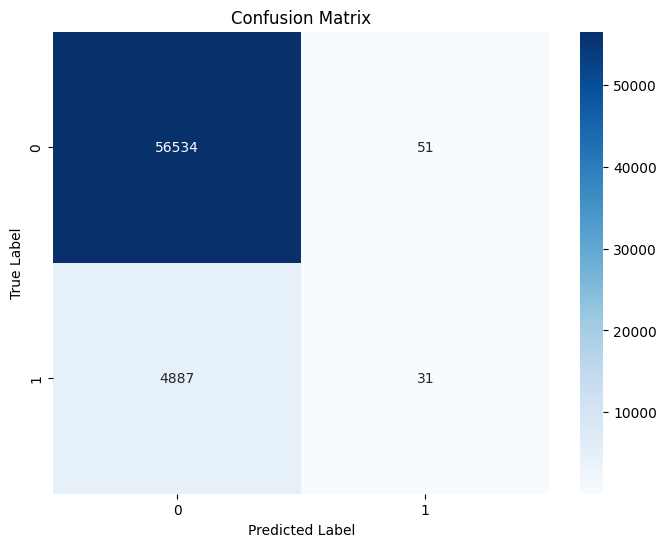

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = predictions.select("TARGET").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Oversampling

Phương pháp đề ra để giải quyết là oversampling dữ liệu để số người có khả năng trả nợ cân bằng với số người không trả được nợ.

=> Oversampling tập train và giữ nguyên tập test

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

(trainingData, testData) = data_join.randomSplit([0.8, 0.2], seed=123)

majority_class = trainingData.filter(col("TARGET") == 0)
minority_class = trainingData.filter(col("TARGET") == 1)

ratio = majority_class.count() / minority_class.count()

oversampled_minority = minority_class.withColumn("dummy", F.explode(F.array_repeat(F.lit(None), int(ratio)))) \
    .drop("dummy")

oversampled_trainingData = majority_class.unionAll(oversampled_minority)

In [ ]:
oversampled_trainingData = oversampled_trainingData.withColumn("total_credit_sum", when(isnull(col("total_credit_sum")), 71326).otherwise(col("total_credit_sum"))) \
    .withColumn("avg_credit_sum_debt", when(isnull(col("avg_credit_sum_debt")), 71326).otherwise(col("avg_credit_sum_debt"))) \
    .withColumn("num_loans", when(isnull(col("num_loans")), 71326).otherwise(col("num_loans")))


Với tập train và test mới huận luyện lại mô hình.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when, isnull

(trainingData, testData) = data_join.randomSplit([0.8, 0.2], seed=123)

stages = []
for categoricalCol in categorical_cols:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid='keep') # Add handleInvalid='keep' to the StringIndexer
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep") # Set handleInvalid to 'keep'
stages += [assembler]

for col_name in numeric_cols:
    trainingData = trainingData.withColumn(col_name, when(isnull(col(col_name)), 0).otherwise(col(col_name)))
    testData = testData.withColumn(col_name, when(isnull(col(col_name)), 0).otherwise(col(col_name)))


lr = LogisticRegression(featuresCol="features", labelCol="TARGET", maxIter=10)
stages += [lr]

pipeline = Pipeline(stages=stages)

model = pipeline.fit(oversampled_trainingData)

predictions = model.transform(testData)

evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area under ROC curve:", auc)

evaluator_acc = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
print("Accuracy:", accuracy)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print("Recall:", recall)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print("Precision:", precision)

Area under ROC curve: 0.67913349489191
Accuracy: 0.6934783669089313
Recall: 0.6934783669089313
Precision: 0.8955271636474341


Kết quả trả về khá tốt với AUC-ROC cải thiện đáng kể (gần 70%)

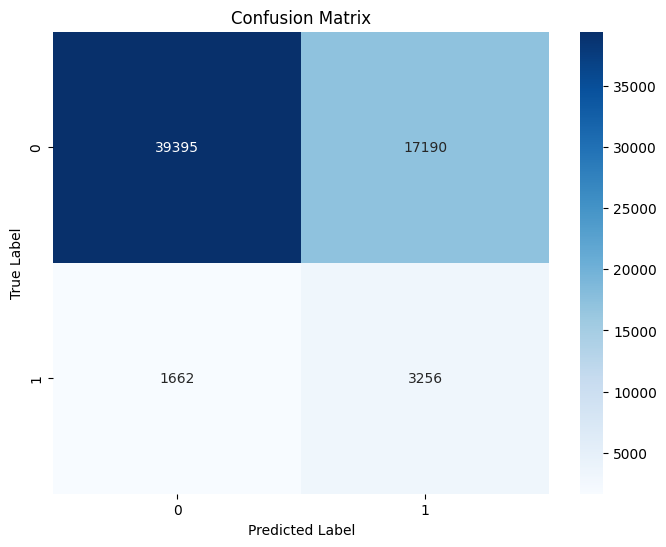

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = predictions.select("TARGET").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
